In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import mrcfile
import time
try:
   import cupy as cp
except ImportError:
   use_cupy = True

In [109]:
fp = "/mnt/experiment/TEM diffraction/210312/sample49_TiiGe44_top_AD/Camera 230 mm Ceta 20210312 1337_50s_20f_area02.mrc"
# fp = "V:/experiment/210312/sample53_TiGe15_bot_AD/Camera 230 mm Ceta 20210312 1755_50s_20f_area08.mrc"

def load_mrc_img(fp):
    with mrcfile.open(fp) as mrc:
        raw_img = mrc.data
    easy_img = np.log(np.abs(raw_img)+1)
    easy_img = easy_img / easy_img.max() * 255
    easy_img = easy_img.astype('uint8')
    return raw_img, easy_img

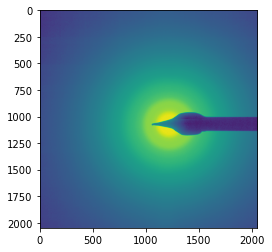

In [110]:
raw,img = load_mrc_img(fp)
plt.imshow(img)

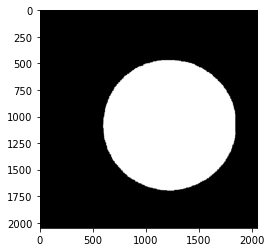

In [111]:
# blur = cv2.GaussianBlur(img, (5,5), 0)
def get_initial_center(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
    plt.imshow(thresh)

    kernel = np.ones((20, 20), np.uint8)
    # thresh = cv2.erode(thresh,kernel, iterations=3)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    kernel = np.ones((200, 200), np.uint8)
    # thresh = cv2.erode(thresh,kernel, iterations=3)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    plt.imshow(thresh, cmap='gray')
    thresh = np.uint8(thresh / 255)

    mesh = np.meshgrid(np.arange(thresh.shape[0]), np.arange(thresh.shape[1]))
    center_x = np.sum(mesh[0] * thresh) / np.sum(thresh)
    center_y = np.sum(mesh[1] * thresh) / np.sum(thresh)
    return center_x, center_y

c_x, c_y = get_initial_center(img)

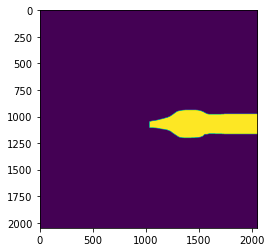

In [112]:
def create_estimated_mask(c_x,c_y):
    x1 = 900
    x2 = 1250
    y1 = 900
    # plt.imshow(img[x1:x2,y1:])
    img_slice = img[x1:x2,y1:]
    thresh = cv2.inRange(img_slice,0,130)
    thresh[0:100,700:]=0
    thresh[240:,700:]=0
    beam_mask = np.zeros(img.shape)
    beam_mask[x1:x2,y1:]=thresh

    c_x=np.uint16(c_x)
    c_y=np.uint16(c_y)

    kernel = np.ones((50,50),np.uint8)
    beam_mask = cv2.dilate(beam_mask,kernel,1)
    mask = cv2.circle(beam_mask, (c_x,c_y),50,255,-1)
    mask = np.uint8(mask)
    return mask

beam_mask = create_estimated_mask(c_x,c_y)
plt.imshow(beam_mask)

In [113]:
def get_rectangle_from_intensity(image, intensity_range):
    i1, i2 = intensity_range
    kernel_size = 2
    msk = cv2.inRange(image, i1, i2)
    kernel1 = np.ones((kernel_size, kernel_size), np.uint8)
    msk = cv2.erode(msk, kernel1)
    nonzero = np.nonzero(msk)
    p1_y = nonzero[0].min()-2
    p1_x = nonzero[1].min()-2
    p2_y = nonzero[0].max()+2
    p2_x = nonzero[1].max()+2
    return (p1_y,p1_x,p2_y,p2_x)

In [114]:
def evaluate_center(img, center, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = 0
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = cv2.inRange(img,current_min_i,current_max_i)
        ring_mask = cv2.bitwise_and(ring_mask,ring_mask,mask=(np.logical_not(beam_mask)*255).astype(np.uint8))
        # 0.02

        mesh = np.meshgrid(range(img.shape[0]),range(img.shape[1]))
        mesh_x = mesh[0]-center_x
        mesh_y = mesh[1]-center_y
        # 0.03

        ring_x = cv2.bitwise_and(mesh_x,mesh_x,mask=ring_mask)
        ring_y = cv2.bitwise_and(mesh_y,mesh_y,mask=ring_mask)
        # 0.03


        dt = np.power(np.square(ring_x)+np.square(ring_y),0.5)
        dt = dt.reshape(-1)
        std_sum += np.std(dt[np.nonzero(dt)[0]])

    return std_sum

tic = time.clock()
print(evaluate_center(img,(c_x,c_y),(130,135),1))
toc = time.clock()
print(toc-tic)

13.849430647188596
0.0905920000000151


/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [115]:
def evaluate_center_slice(image, center, rect, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range

    p1_y,p1_x,p2_y,p2_x = rect

    y_width_origin = p2_y-p1_y
    x_width_origin = p2_x-p1_x
    h_y_width_origin = int(y_width_origin/2)
    h_x_width_origin = int(x_width_origin/2)

    p1y=np.max((center_y-h_y_width_origin,0)).astype(np.uint16)
    p2y=np.min((center_y+h_y_width_origin,image.shape[0])).astype(np.uint16)
    p1x=np.max((center_x-h_x_width_origin,0)).astype(np.uint16)
    p2x=np.min((center_x+h_x_width_origin,image.shape[1])).astype(np.uint16)

    y_width = p2_y-p1_y
    x_width = p2_x-p1_x
    h_y_width = int(y_width/2)
    h_x_width = int(x_width/2)

    slc_img = image[p1y:p2y,p1x:p2x]
    slc_beam_mask = beam_mask[p1y:p2y,p1x:p2x]

    # slc_beam_mask = beam_mask[center_y-h_y_width:center_y+h_y_width,center_x-h_x_width:center_x+h_x_width]
    slc_center_y = center_y - p1y
    slc_center_x = center_x - p1x

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = 0
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = cv2.inRange(slc_img,current_min_i,current_max_i)
        ring_mask = cv2.bitwise_and(ring_mask,ring_mask,mask=(np.logical_not(slc_beam_mask)*255).astype(np.uint8))

        mesh = np.meshgrid(range(slc_img.shape[1]),range(slc_img.shape[0]))
        mesh_y = mesh[1]-slc_center_y
        mesh_x = mesh[0]-slc_center_x

        ring_x = cv2.bitwise_and(mesh_x,mesh_x,mask=ring_mask)
        ring_y = cv2.bitwise_and(mesh_y,mesh_y,mask=ring_mask)

        dt = np.power(np.square(ring_x)+np.square(ring_y),0.5)
        dt = dt.reshape(-1)
        std_sum += np.std(dt[np.nonzero(dt)[0]])

    return std_sum

tic = time.clock()
intensity_rang = (130,135)
rectan = get_rectangle_from_intensity(img,intensity_rang)
print(evaluate_center_slice(img,(c_x,c_y),[0,0,4048,4048],intensity_rang,1))
toc = time.clock()
print(toc-tic)

13.849430647188596
0.1275669999999991


/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


min value: 13.747604930984048
min index: (3, 4)


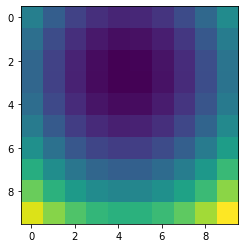

In [116]:
_intensity_range = (130,135)
find_range = 5

xy = np.zeros((find_range*2,find_range*2))
for x in range(-find_range,find_range):
    for y in range(-find_range,find_range):
        xy[x+find_range,y+find_range]=evaluate_center(img,(c_x+x,c_y+y),_intensity_range,1)

min_index = np.unravel_index(xy.argmin(), xy.shape)
real_index = np.zeros(2)
real_index[0] = min_index[0] - find_range
real_index[1] = min_index[1] - find_range
real_center = np.add((c_x,c_y),real_index).astype('int')

plt.imshow(xy)
print("min value:",xy.min())
print("min index:",np.unravel_index(xy.argmin(), xy.shape))

min value: 13.720971766500623
min index: (3, 4)


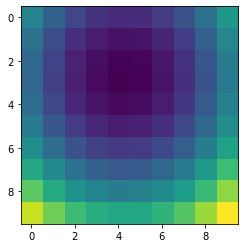

In [84]:
_intensity_range = (130,135)
rec = get_rectangle_from_intensity(img,_intensity_range)
find_range = 5

xy = np.zeros((find_range*2,find_range*2))
for x in range(-find_range,find_range):
    for y in range(-find_range,find_range):
        xy[x+find_range,y+find_range]=evaluate_center_slice(img,(c_x+x,c_y+y),rec,_intensity_range,1)

plt.imshow(xy)
print("min value:",xy.min())
print("min index:",np.unravel_index(xy.argmin(), xy.shape))

In [85]:
def evaluate_center_slice_range(image, center, rect, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range
    shift_range = 5

    p1_y,p1_x,p2_y,p2_x = rect

    y_width_origin = p2_y-p1_y
    x_width_origin = p2_x-p1_x
    h_y_width_origin = int(y_width_origin/2)
    h_x_width_origin = int(x_width_origin/2)

    p1y=np.max((center_y-h_y_width_origin,0)).astype(np.uint16)
    p2y=np.min((center_y+h_y_width_origin,image.shape[0])).astype(np.uint16)
    p1x=np.max((center_x-h_x_width_origin,0)).astype(np.uint16)
    p2x=np.min((center_x+h_x_width_origin,image.shape[1])).astype(np.uint16)

    y_width = p2_y-p1_y
    x_width = p2_x-p1_x
    h_y_width = int(y_width/2)
    h_x_width = int(x_width/2)

    slc_img = image[p1y:p2y,p1x:p2x]
    slc_beam_mask = beam_mask[p1y:p2y,p1x:p2x]

    # slc_beam_mask = beam_mask[center_y-h_y_width:center_y+h_y_width,center_x-h_x_width:center_x+h_x_width]
    slc_center_y = h_y_width
    slc_center_x = h_x_width
    slc_center_y = center_y - p1y
    slc_center_x = center_x - p1x

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = 0
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = cv2.inRange(slc_img,current_min_i,current_max_i)
        ring_mask = cv2.bitwise_and(ring_mask,ring_mask,mask=(np.logical_not(slc_beam_mask)*255).astype(np.uint8))

        mesh = np.meshgrid(range(slc_img.shape[1]),range(slc_img.shape[0]))
        mesh_y = mesh[1]-slc_center_y
        mesh_x = mesh[0]-slc_center_x

        ring_x = cv2.bitwise_and(mesh_x,mesh_x,mask=ring_mask)
        ring_y = cv2.bitwise_and(mesh_y,mesh_y,mask=ring_mask)
        
        dt = np.power(np.square(ring_x)+np.square(ring_y),0.5)
        dt = dt.reshape(-1)
        std_sum += np.std(dt[np.nonzero(dt)[0]])

    return std_sum

tic = time.clock()
intensity_rang = (130,135)
rectan = get_rectangle_from_intensity(img,intensity_rang)
print(evaluate_center_slice_range(img,(c_x,c_y),[0,0,4048,4048],intensity_rang,1))
toc = time.clock()
print(toc-tic)

13.849430647188596
0.10520399999998631


/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [25]:
def evaluate_center_slice_range_cupy(image, center, rect, value_range, step_size):

    center_x, center_y = center
    center_x = int(center_x)
    center_y = int(center_y)
    min_i,max_i = value_range
    shift_range = 5

    p1_y,p1_x,p2_y,p2_x = rect

    y_width_origin = p2_y-p1_y
    x_width_origin = p2_x-p1_x
    h_y_width_origin = int(y_width_origin/2)
    h_x_width_origin = int(x_width_origin/2)

    p1y=np.max((center_y-h_y_width_origin,0)).astype(np.uint16)
    p2y=np.min((center_y+h_y_width_origin,image.shape[0])).astype(np.uint16)
    p1x=np.max((center_x-h_x_width_origin,0)).astype(np.uint16)
    p2x=np.min((center_x+h_x_width_origin,image.shape[1])).astype(np.uint16)

    y_width = p2_y-p1_y
    x_width = p2_x-p1_x
    h_y_width = int(y_width/2)
    h_x_width = int(x_width/2)

    slc_img = cp.array(image[p1y:p2y,p1x:p2x])
    slc_beam_mask = cp.array(beam_mask[p1y:p2y,p1x:p2x])

    # slc_beam_mask = beam_mask[center_y-h_y_width:center_y+h_y_width,center_x-h_x_width:center_x+h_x_width]
    slc_center_y = h_y_width
    slc_center_x = h_x_width
    slc_center_y = center_y - p1y
    slc_center_x = center_x - p1x

    if step_size > 0:
        range_ = np.linspace(min_i,max_i,step_size+1)
    std_sum = cp.zeros((shift_range*2,shift_range*2))
    for step in range(len(range_)-1):
        current_min_i = int(range_[step])
        current_max_i = int(range_[step+1])

        ring_mask = (current_max_i >= slc_img) & (slc_img > current_min_i)
        ring_mask = ring_mask & cp.bitwise_not(slc_beam_mask)
#         ring_mask = ring_mask.astype('float')
#         cp.putmask(ring_mask,ring_mask==0,cp.nan)
#         print(cp.sum(ring_mask==np.nan))
#         plt.imshow(ring_mask.get())
        mesh = cp.meshgrid(cp.arange(-slc_center_x,-slc_center_x+slc_img.shape[1]),
                           cp.arange(-slc_center_y,-slc_center_y+slc_img.shape[0]))
        new_mesh_y = mesh[1][:,:,None]+cp.arange(-shift_range,shift_range)
        new_mesh_x = mesh[0][:,:,None]+cp.arange(-shift_range,shift_range)
        new_mesh_y = new_mesh_y.transpose(2,0,1)
        new_mesh_x = new_mesh_x.transpose(2,0,1)
        
        
        ring_x = new_mesh_x*ring_mask
        ring_y = new_mesh_y*ring_mask
        # work done

        ring_x = cp.square(ring_x)
        ring_y = cp.square(ring_y)
        #

        # for xx in range(2*shift_range):
        #     for yy in range(2*shift_range):
        #
        #
        #         ring_some = ring_x[xx]+ring_y[yy]
        #         ring_some = cp.where(ring_some!=0,ring_some,cp.nan)
        #         ring_some = cp.power(ring_some,0.5)
        #         std_sum[yy,xx]=cp.nanstd(ring_some)


        ring_xy = ring_x[:,:,:,None]+cp.zeros(2*shift_range)
        # ring_xy = ring_xy.transpose(3,0,1,2)
        ring_xy = ring_xy.transpose(0,3,1,2)
        for rol in range(ring_xy.shape[0]):
            ring_xy[rol] = ring_xy[rol] + cp.roll(ring_y,-rol,axis=0)
        ring_xy = cp.add(ring_xy,ring_y)
        ring_xy = cp.power(ring_xy,0.5)
        dt = cp.where(ring_xy!=0,ring_xy,cp.nan)
        std_sum += cp.nanstd(dt,axis=(2,3))
        
        
    std_sum = std_sum.get()
    return std_sum

tic = time.process_time()
intensity_rang = (130,135)
rectan = get_rectangle_from_intensity(img,intensity_rang)
picture = evaluate_center_slice_range_cupy(img,(c_x,c_y),[0,0,4048,4048],intensity_rang,1)
toc = time.process_time()
print(toc-tic)

1.5463876120000037


min value: 5957.024721151335
min index: (8, 6)


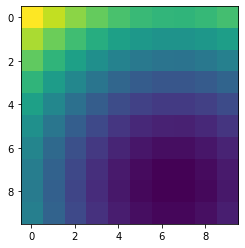

In [11]:
plt.imshow(picture)
print("min value:",picture.min())
print("min index:",np.unravel_index(picture.argmin(), picture.shape))

min value: 59.32424742570789
min index: (0, 6)


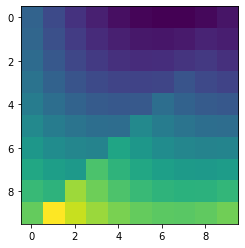

In [26]:
plt.imshow(picture)
print("min value:",picture.min())
print("min index:",np.unravel_index(picture.argmin(), picture.shape))

In [3]:
import numpy as np
mesh = np.meshgrid(range(10),range(10))[1]
mesh

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

In [7]:
np.roll(mesh,-2,axis=0)

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
plt.imshow(picture)
print("min value:",picture.min())
print("min index:",np.unravel_index(picture.argmin(), picture.shape))

In [ ]:
# imagine = cp.ones((img.shape[0],img.shape[1]))[None,:,:]*cp.arange(0,10)
# imagine = imagine.transpose(2,0,1)
# # imagine = None
# print(mempool.used_bytes()/1024/1024)              # 0
# print(mempool.total_bytes()/1024/1024)             # 0

In [ ]:
# meshgrid = cp.meshgrid(cp.arange(-c_x,-c_x+img.shape[0]),cp.arange(-c_y,-c_y+img.shape[1]))
# mesh_x = meshgrid[0][:,:,None]+cp.arange(-10,10)
# mesh_y = meshgrid[0][:,:,None]+cp.arange(-10,10)

In [ ]:
# # np.array(10).transpose(1,-1)
# a = np.arange(75).reshape(5,5,3)[:,:,:,None]+np.zeros(10)
# a = a.transpose(3,0,1,2)
# b = np.arange(75).reshape(5,5,3)
# np.add(a,b)
# np.nonzero(np.array([[1,2,0,3,4],[2,3,1,0,4]]))

In [ ]:
# mempool = cp.get_default_memory_pool()
# pinned_mempool = cp.get_default_pinned_memory_pool()
# # mempool.used_bytes()
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()
# print(mempool.used_bytes()/1024/1024)              # 0
# print(mempool.total_bytes()/1024/1024)             # 0
# print(pinned_mempool.n_free_blocks())    # 0

In [ ]:
#     nazav = np.zeros((n_rr+1,1))
#     azav = np.zeros((n_rr+1,1))
# tic = time.clock()
# for n in range(1,n_rr) :
#     rig_mask = np.uint8(rr==n)
#     rig = cv2.bitwise_and(image,image,mask=rig_mask)
#     # rig = image*rig_mask
#     rig = rig.reshape((-1))
#     non_zero = np.nonzero(rig)[0]
#     azav[n] = np.average(rig[non_zero])
# toc = time.clock()
# print(toc-tic)

In [86]:
def get_azimuthal_average(raw_image,center):
    center_x, center_y = center
    mesh = np.meshgrid(range(raw_image.shape[1]), range(raw_image.shape[0]))
    mesh_x = mesh[0] - center_x
    mesh_y = mesh[1] - center_y
    rr = np.power(np.square(mesh_x) + np.square(mesh_y), 0.5)
    rr = cv2.bitwise_and(rr, rr, mask=np.bitwise_not(beam_mask))
    n_rr = np.uint16(np.ceil(rr.max()))

    def vector_oper(r):
        masked_img = raw_image[(rr >= r - .5) & (rr < r + .5)]
        return masked_img.mean(), masked_img.var()

    # f = lambda r: raw_image[(rr >= r - .5) & (rr < r + .5)].mean()
    r = np.linspace(1, n_rr, num=n_rr)
    mean, var = np.vectorize(vector_oper)(r)
    mean = np.nan_to_num(mean, 0)
    var = np.nan_to_num(var, 0)

    return mean, var

In [107]:
def get_azimuthal_mean_cuda(raw_image,center):
    img = cp.array(raw_image)
    beam = cp.array(beam_mask)
    center_x, center_y = center
    
    mesh = cp.meshgrid(cp.arange(raw_image.shape[1]),cp.arange(raw_image.shape[0]))
    mesh_x = mesh[0] - center_x
    mesh_y = mesh[1] - center_y
    rr = cp.power(cp.square(mesh_x)+cp.square(mesh_y),0.5)
    cp.putmask(rr, beam, 0)
    n_rr = int(cp.ceil(rr.max()))
    
    azav = cp.zeros((n_rr+1))
    azvar = cp.zeros((n_rr+1))
    for n in range(1,n_rr) :

        rig_mask = (rr >= n-0.5) & (rr < n+0.5)
        rig = img[rig_mask]
        azav[n] = rig.mean()
        azvar[n] = rig.var()

        # rig_mask = (rr >= n-0.5) & (rr < n+0.5)
        # rig = img*rig_mask
        # rig = rig.reshape((-1))
        # non_zero = cp.nonzero(rig)[0]
        # azav[n] = cp.average(rig[non_zero])
        # azvar[n] = cp.var(rig[non_zero])

    azav = np.nan_to_num(azav.get(),0)
    azvar = np.nan_to_num(azvar.get(),0)
    return azav,azvar

/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


0.7366710000000012


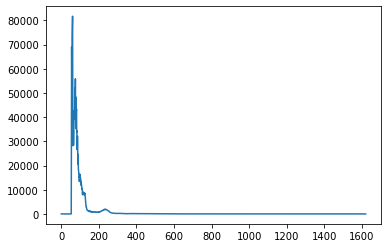

In [132]:
center_x,center_y = real_center
tic = time.clock()
az_mean,az_var = get_azimuthal_mean_cuda(raw,(center_x-2,center_y-4))
toc = time.clock()
print(toc-tic)
plt.plot(az_var)

In [ ]:
import itertools
size = 20
xy =np.array(list(itertools.product(range(size),range(size))))
xy_output = np.zeros((size,size))
for x,y in xy:
    xy_output[x,y] = get_azimuthal_mean_cuda(raw,(center_x+x-5,center_y+y-5))[1].max()

In [ ]:
plt.imshow(xy_output)

/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  if sys.path[0] == '':
/home/pilsung/anaconda3/envs/cv/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pilsun

6.474378999999999


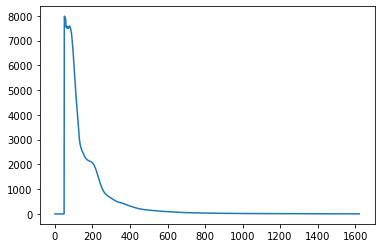

In [130]:
tic = time.clock()
az_mean,az_var = get_azimuthal_average(raw,(c_x-3,c_y-3))
toc = time.clock()
print(toc-tic)
plt.plot(az_mean)

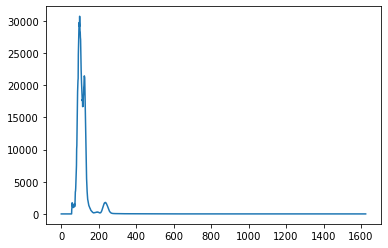

In [40]:
plt.plot(az_var)

In [ ]:
# tic = time.clock()
# for yy in range(image.shape[0]):
#     for xx in range(image.shape[1]):
#         kk = rr[yy,xx]
#         if kk==0: continue
#         nazav[kk]+=1
#         azav[kk]+=image[yy,xx]
# for r in range(n_rr):
#     azav[r] = azav[r]/nazav[r]
# toc = time.clock()
# print(toc-tic)



In [ ]:
newX = np.ma.array(np.array([1,2,3,4]), mask = [1,0,1,0])

In [ ]:
newX.min()

In [ ]:
cupy.putmask(x, x>2, x**2)

In [ ]:
colorcube = np.loadtxt("./assets/colorcube.csv",delimiter=",",dtype=np.float32)
def gray2colorcube(img, cmap):
    assert len(img.shape)==2 # img should be gray img
    if img.dtype != np.uint8:
        print("rescale to uint8")
        img = img / np.max(img) * len(cmap)
        img = img.astype(np.uint8)

    new_img = np.zeros((img.shape[0],img.shape[1],3))
#     for idx, val in np.ndenumerate(img):
#         new_img[idx] = colorcube[val]
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            new_img[x,y] = colorcube[img[x,y]]
    return new_img

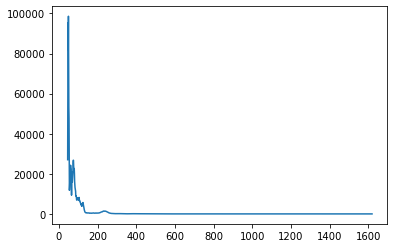

In [90]:
hi = np.loadtxt('/mnt/experiment/TEM diffraction/210312/sample49_TiiGe44_top_AD/Analysis/Camera 230 mm Ceta 20210312 1337_50s_20f_area02_azvar.txt')
plt.plot(hi)